In [68]:
# scripts/daily_trade_suggestions.py

import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
import json
from pathlib import Path

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12,6)

# -------------------------
# Folders
# -------------------------
DATA_DAILY = Path("data/daily")
HOT_SCORE_OUT = Path("data/hotscore")
FINAL_OUT = Path("output/recommendations")
FINAL_OUT_APPEARANCES = Path("output/appearances")
FINAL_OUT_DAILY = Path("output/daily")

for p in (DATA_DAILY, HOT_SCORE_OUT, FINAL_OUT,FINAL_OUT_APPEARANCES, FINAL_OUT_DAILY):
    p.mkdir(parents=True, exist_ok=True)

# -------------------------
# Parameters
# -------------------------
MIN_DAYS_HISTORY = 30
PERSISTENT_DAYS = 180
STREAK_THRESHOLD = 3
TOP_N_PERSISTENT = 10
FORWARD_HORIZONS = [1, 5, 20]
TOP_SYMBOLS_PLOT = 60

# -------------------------
# Load daily hot stocks
# -------------------------
files = sorted(glob.glob(str(DATA_DAILY / "hot_stocks_*.csv")))
if not files:
    raise FileNotFoundError(f"No hot stocks files found in {DATA_DAILY}")

dfs = []
for f in files:
    df = pd.read_csv(f)
    date_tag = Path(f).stem.replace("hot_stocks_", "")
    df['date'] = pd.to_datetime(date_tag, format="%Y%m%d%H%M%S")
    if 'symbol' not in df.columns and 'Symbol' in df.columns:
        df = df.rename(columns={'Symbol':'symbol'})
    dfs.append(df)

full_df = pd.concat(dfs, ignore_index=True, sort=False)

# Ensure numeric columns
cols_num = ['regularMarketPrice','regularMarketChangePercent','regularMarketVolume',
            'averageDailyVolume3Month','marketCap','HotScore','VolumeSpike',
            'MomentumScore','VolumeScore','VolatilityScore','TrendScore']

for c in cols_num:
    if c in full_df.columns:
        full_df[c] = pd.to_numeric(full_df[c], errors='coerce')

keep_cols = ['symbol','date','HotScore','regularMarketPrice','regularMarketChangePercent',
             'VolumeSpike','averageDailyVolume3Month','marketCap']
for c in keep_cols:
    if c not in full_df.columns:
        full_df[c] = np.nan

full_df = full_df[keep_cols]
full_df['symbol'] = full_df['symbol'].astype(str).str.upper()
full_df = full_df.sort_values(['date','symbol']).reset_index(drop=True)

# -------------------------
# Save HotScore snapshot
# -------------------------
timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
hotscore_file = HOT_SCORE_OUT / f"hotscore_{timestamp}.csv"
full_df.to_csv(hotscore_file, index=False)
print("Saved HotScore data:", hotscore_file)

# -------------------------
# Heatmap for top symbols
# -------------------------
top_symbols = full_df['symbol'].value_counts().head(TOP_SYMBOLS_PLOT).index.tolist()
pivot = full_df[full_df['symbol'].isin(top_symbols)].pivot_table(
    index='symbol', columns='date', values='HotScore', aggfunc='mean'
)
pivot = pivot.assign(avg=pivot.mean(axis=1)).sort_values('avg', ascending=False).drop(columns='avg')


Saved HotScore data: data\hotscore\hotscore_20251126154307.csv


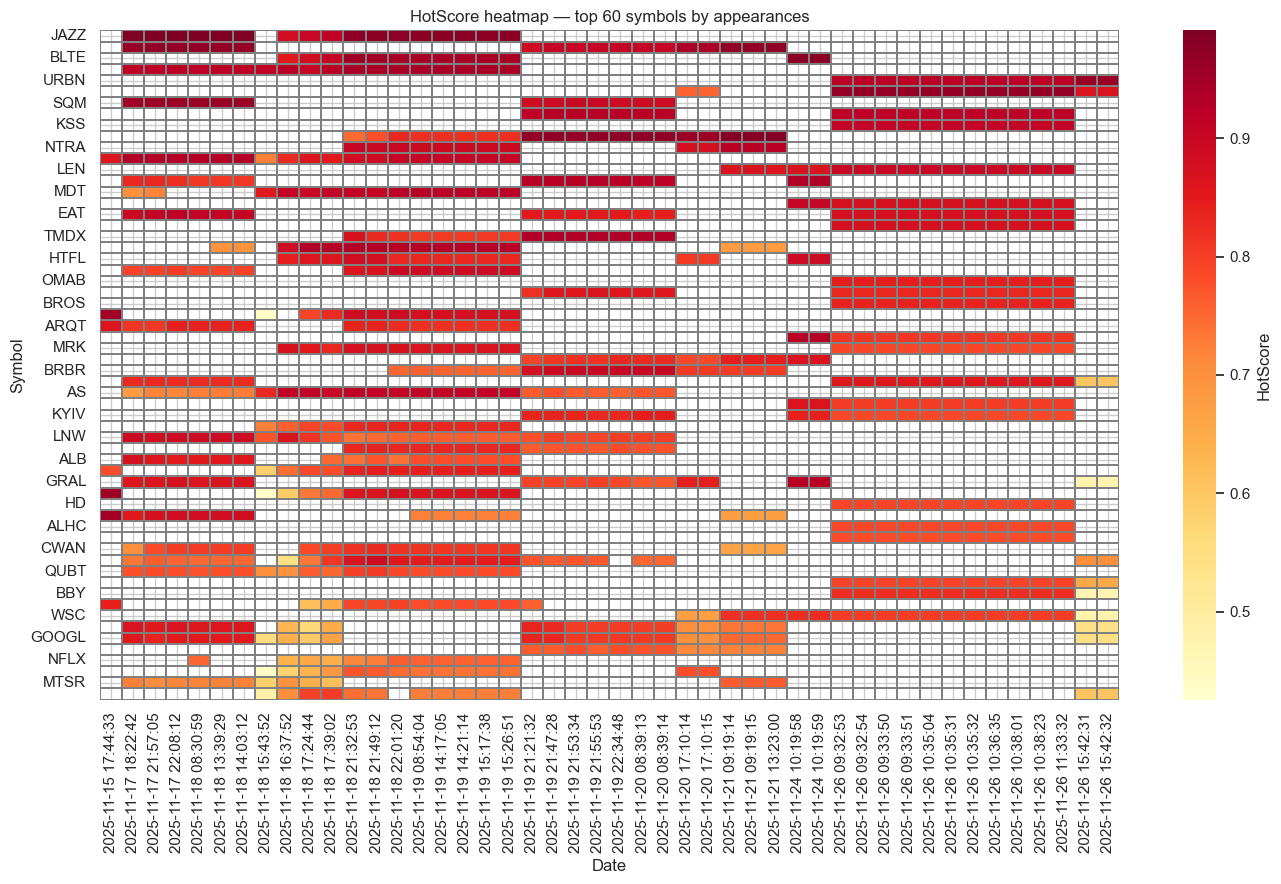

Saved heatmap: output\recommendations\heatmap_hotscore_20251126154307.png


In [69]:

timestamp = datetime.now().strftime("%Y%m%d%H%M%S")

heatmap_file = FINAL_OUT / f"heatmap_hotscore_{timestamp}.png"
plt.figure(figsize=(14, max(6, 0.15*len(pivot))))
sns.heatmap(pivot, cmap='YlOrRd', linewidths=0.3, linecolor='gray', cbar_kws={'label':'HotScore'})
plt.title(f"HotScore heatmap — top {len(pivot)} symbols by appearances")
plt.xlabel("Date")
plt.ylabel("Symbol")
plt.tight_layout()
plt.savefig(heatmap_file, dpi=200)
plt.show()
plt.close()
print("Saved heatmap:", heatmap_file)


In [70]:

dates = sorted(full_df['date'].unique())
symbols = sorted(full_df['symbol'].unique())
presence = pd.DataFrame(0, index=symbols, columns=dates)
for d in dates:
    syms = full_df.loc[full_df['date']==d, 'symbol'].unique()
    presence.loc[syms, d] = 1

def consecutive_streak(series):
    arr = series.values
    streaks = np.zeros_like(arr, dtype=int)
    current = 0
    for i, v in enumerate(arr):
        if v==1:
            current +=1
            streaks[i]=current
        else:
            current =0
            streaks[i]=0
    return streaks

streaks = presence.apply(consecutive_streak, axis=1, result_type='expand')
streaks.columns = dates
latest_date = dates[-1]
current_streak = streaks[latest_date].sort_values(ascending=False)
streak_df = current_streak.reset_index().rename(columns={'index':'symbol', latest_date:'current_streak'})
streak_df = streak_df[streak_df['current_streak']>=STREAK_THRESHOLD]
streak_symbols = streak_df

window_end = full_df['date'].max()
window_start = window_end - pd.Timedelta(days=PERSISTENT_DAYS)
window_df = full_df.loc[(full_df['date']>=window_start) & (full_df['date']<=window_end)].copy()

stats = window_df.groupby('symbol').agg(
    appearances = ('date','nunique'),
    avg_HotScore = ('HotScore','mean'),
    median_HotScore = ('HotScore','median')
).sort_values(['appearances','avg_HotScore'], ascending=False)

persistent_top = stats.head(TOP_N_PERSISTENT)

candidates = sorted(set(streak_symbols['symbol'].tolist()) | set(persistent_top.index.tolist()))

# -------------------------
# Technical checks
# -------------------------
def technical_checks(symbol):
    try:
        hist = yf.download(symbol, period="1y", interval="1d", progress=False, auto_adjust=True)
        if hist.empty:
            return None
        close = hist['Close']
        vol = hist['Volume'] if 'Volume' in hist.columns else None
        price = float(close.iloc[-1])
        ma50 = float(close.rolling(50).mean().iloc[-1])
        return {'symbol':symbol,'price':price,'ma50':ma50}
    except:
        return None

tech_rows=[]
for s in candidates:
    r = technical_checks(s)
    if r: tech_rows.append(r)
tech_df = pd.DataFrame(tech_rows).set_index('symbol')

# -------------------------
# Forward returns
# -------------------------
def forward_returns_for_symbol(symbol, appear_dates, horizons=[1,5,20]):
    hist = yf.download(symbol, period="2y", interval="1d", progress=False, auto_adjust=True)
    if hist.empty:
        return None
    close = hist['Close']
    results=[]
    for date in appear_dates:
        idx = close.index.searchsorted(pd.to_datetime(date))
        if idx >= len(close):
            continue
        base_price = close.iloc[idx]
        row={'date':date}
        for h in horizons:
            fidx = idx+h
            row[f"ret_fwd_{h}d"] = (close.iloc[fidx]/base_price - 1)*100 if fidx < len(close) else np.nan
        results.append(row)
    if not results:
        return None
    return pd.DataFrame(results)

agg_rows=[]
for s in candidates:
    dates_s = full_df.loc[full_df['symbol']==s,'date'].dt.strftime("%Y-%m-%d").unique().tolist()
    df_f = forward_returns_for_symbol(s, dates_s, FORWARD_HORIZONS)
    if df_f is None: continue
    mean_row={'symbol':s}
    for h in FORWARD_HORIZONS:
        mean_row[f"mean_ret_fwd_{h}d"] = df_f[f"ret_fwd_{h}d"].mean(skipna=True)
    mean_row['appearances'] = len(dates_s)
    agg_rows.append(mean_row)

agg_df = pd.DataFrame(agg_rows).set_index('symbol')
agg_df = agg_df.sort_values(f"mean_ret_fwd_{FORWARD_HORIZONS[1]}d", ascending=False)


C:\Users\a73s\AppData\Local\Temp\ipykernel_13008\2593787727.py:53: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(close.iloc[-1])
C:\Users\a73s\AppData\Local\Temp\ipykernel_13008\2593787727.py:54: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ma50 = float(close.rolling(50).mean().iloc[-1])
C:\Users\a73s\AppData\Local\Temp\ipykernel_13008\2593787727.py:53: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(close.iloc[-1])
C:\Users\a73s\AppData\Local\Temp\ipykernel_13008\2593787727.py:54: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ma50 = float(close.rolling(50).mean().iloc[-

In [71]:

# -------------------------
# Build trade suggestions
# -------------------------
def build_trade_suggestions(tech_df, agg_df, persistent_top, output_folder=FINAL_OUT):
    output_folder = Path(output_folder)
    output_folder.mkdir(parents=True, exist_ok=True)
    all_symbols = sorted(set(tech_df.index) | set(agg_df.index) | set(persistent_top.index))
    rec = pd.DataFrame(index=all_symbols)
    rec = rec.join(tech_df, how='left')
    rec = rec.join(agg_df, how='left')
    rec = rec.join(persistent_top[['appearances','avg_HotScore']].rename(
        columns={'appearances':'appearances_persistent'}
    ), how='left')

    for col in ['price','ma50','mean_ret_fwd_5d','appearances_persistent','avg_HotScore']:
        if col not in rec.columns:
            rec[col] = 0
        else:
            rec[col] = pd.to_numeric(rec[col], errors='coerce').fillna(0)

    rec['rule_score']=0
    rec['rule_score'] += (rec['price']>rec['ma50']).astype(int)*2
    rec['rule_score'] += (rec['mean_ret_fwd_5d']>0).astype(int)*2
    rec['rule_score'] += (rec['appearances_persistent']>=3).astype(int)*1
    rec['rule_score'] += (rec['avg_HotScore']>rec['avg_HotScore'].median()).astype(int)*1

    rec = rec.sort_values(['rule_score','mean_ret_fwd_5d'], ascending=[False, False])

    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    rec_file = output_folder / f"trade_suggestions_{timestamp}.csv"
    rec.to_csv(rec_file)
    return rec, rec_file

rec_df, rec_file = build_trade_suggestions(tech_df, agg_df, persistent_top, FINAL_OUT)


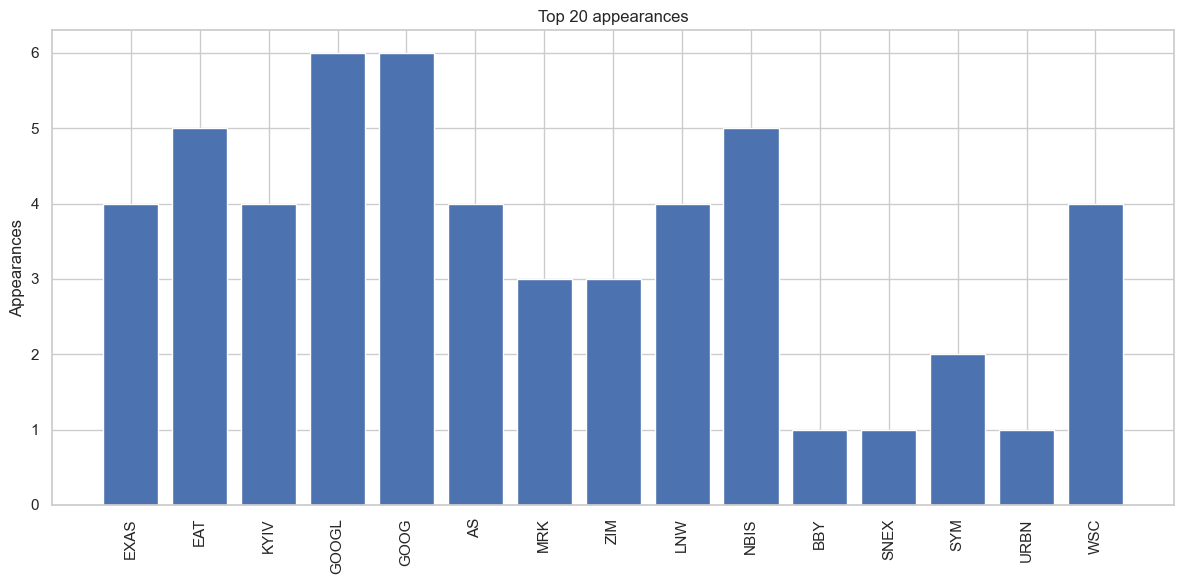

In [72]:
appearance_chart_file = FINAL_OUT_APPEARANCES / f"appearances_{timestamp}.png"

plt.figure(figsize=(12,6))
plt.bar(agg_df.index, agg_df["appearances"])
plt.xticks(rotation=90)
plt.title("Top 20 appearances")
plt.ylabel("Appearances")
plt.tight_layout()
plt.savefig(appearance_chart_file)
plt.show()
plt.close()
